In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the data
def load_data():
    with np.load("notMNIST.npz") as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target

def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test

def shuffle(data, target):
    np.random.seed(421)
    rand_idx = np.random.permutation(len(data))
    return data[rand_idx], target[rand_idx]

In [10]:
# 1.1 Helper Functions
# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def relu(x):
    # TODO
    relu_x = np.maximum(x, 0)
    return relu_x
    # pass


def softmax(x):
    # TODO
    x = x - np.max(x, axis=1, keepdims=True)
    softmax_x = np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
    return softmax_x
    # pass

def compute_layer(x, w, b):
    # TODO
    compute_layer = np.dot(x, w) + b
    return compute_layer
    # pass

def average_ce(target, prediction):
    # TODO
    average_ce = - np.mean(np.multiply(target, np.log(prediction)))
    return average_ce
    # pass

def grad_ce(target, logits):
    # TODO
    grad_ce = logits - target
    return grad_ce
    # pass


In [11]:
# 1.2 Backpropagation Derivation
# the gradient of the loss with respect to the output layer weights.
def dL_dWo(target, logits, hidden_layer_out):
    grad = grad_ce(target, logits)
    dL_dWo = np.dot(hidden_layer_out.T, grad)
    return dL_dWo

# the gradient of the loss with respect to the output layer biases.
def dL_dbo(target, logits):
    ones = np.ones((1, target.shape[0]))
    grad = grad_ce(target, logits)
    dL_dbo = np.dot(ones, grad)
    return dL_dbo

# the gradient of the loss with respect to the hidden layer weights.
def dL_dWh(d_relu, input, target, logits, Wout):
    d_relu[d_relu >= 0] = 1
    d_relu[d_relu < 0] = 0
    grad = grad_ce(target, logits)
    dL_dWh = np.dot(input.T, (d_relu * np.dot(grad, Wout.T)))
    return dL_dWh

# the gradient of the loss with respect to the hidden layer biases.
def dL_dbh(target, logits, d_relu, Wout):
    d_relu[d_relu >= 0] = 1
    d_relu[d_relu < 0] = 0
    ones = np.ones((1, d_relu.shape[0]))
    grad = grad_ce(target, logits)
    dL_dbh = np.dot(ones, (d_relu * np.dot(grad, Wout.T)))
    return dL_dbh

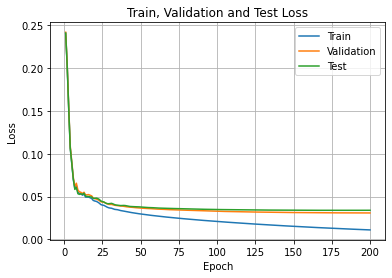

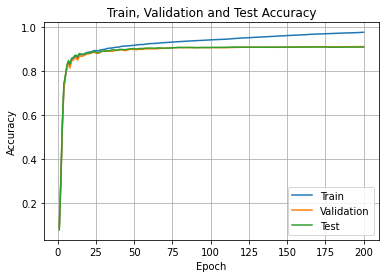

Final train accuracy is: 0.9775
Final validation accuracy is: 0.9121666666666667
Final test accuracy is: 0.9100587371512482


In [14]:
# 1.3 Learning
def train(train_data, train_target, valid_data, valid_target, test_data, test_target, epochs, num_hidden_units, gamma, alpha):
    # initialization
    train_loss = np.zeros(epochs)
    train_accuracy = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    valid_accuracy = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    test_accuracy = np.zeros(epochs)

    Wo = np.random.normal(0, np.sqrt(2 / (num_hidden_units + 10)), (num_hidden_units, 10))
    bo = np.zeros((1, 10))
    Wh = np.random.normal(0, np.sqrt(2 / (28*28 + num_hidden_units)), (28*28, num_hidden_units))
    bh = np.zeros((1, num_hidden_units))
    
    Wo_new = np.zeros((num_hidden_units, 10))
    bo_new = np.zeros((1, 10))
    Wh_new = np.zeros((28*28, num_hidden_units))
    bh_new = np.zeros((1, num_hidden_units))

    train_size = train_data.shape[0]
    valid_size = valid_data.shape[0]
    test_size = test_data.shape[0]
    for i in range(epochs):
      train_hi = compute_layer(train_data, Wh, bh) # hi = hidden input
      train_ho = relu(train_hi) # ho = hidden_output
      train_prediction = softmax(compute_layer(train_ho, Wo, bo))
      train_prediction_label = np.argmax(train_prediction, axis=1)
      train_target_label = np.argmax(train_target, axis=1)
      train_loss[i] = average_ce(train_target, train_prediction)
      train_accuracy[i] = ( np.sum(train_target_label == train_prediction_label) / train_size )

      valid_hi = compute_layer(valid_data, Wh, bh)
      valid_ho = relu(valid_hi)
      valid_prediction = softmax(compute_layer(valid_ho, Wo, bo))
      valid_prediction_label = np.argmax(valid_prediction, axis=1)
      valid_target_label = np.argmax(valid_target, axis=1)
      valid_loss[i] = average_ce(valid_target, valid_prediction)
      valid_accuracy[i] = ( np.sum(valid_target_label == valid_prediction_label) / valid_size )

      test_hi = compute_layer(test_data, Wh, bh)
      test_ho = relu(test_hi)
      test_prediction = softmax(compute_layer(test_ho, Wo, bo))
      test_prediction_label = np.argmax(test_prediction, axis=1)
      test_target_label = np.argmax(test_target, axis=1)
      test_loss[i] = average_ce(test_target, test_prediction)
      test_accuracy[i] = ( np.sum(test_target_label == test_prediction_label) / test_size )
      
      # update
      Wo_new = alpha * dL_dWo(train_target, train_prediction, train_ho) + gamma * Wo_new 
      Wo = Wo - Wo_new
      bo_new = alpha * dL_dbo(train_target, train_prediction) + gamma * bo_new 
      bo = bo - bo_new
      Wh_new = alpha * dL_dWh(train_hi, train_data, train_target, train_prediction, Wo) + gamma * Wh_new 
      Wh = Wh - Wh_new
      bh_new =  alpha * dL_dbh(train_target, train_prediction, train_hi, Wo) + gamma * bh_new 
      bh = bh - bh_new

    # loss plot
    train_label = "Train"
    valid_label = "Validation"
    test_label = "Test"
    plt.title("Train, Validation and Test Loss")
    plt.plot(range(1, len(train_loss) + 1), train_loss, label=train_label)
    plt.plot(range(1, len(train_loss) + 1), valid_loss, label=valid_label)
    plt.plot(range(1, len(train_loss) + 1), test_loss, label=test_label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # accuracy plot
    train_label = "Train"
    valid_label = "Validation"
    test_label = "Test"
    plt.title("Train, Validation and Test Accuracy")
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label=train_label)
    plt.plot(range(1, len(train_accuracy) + 1), valid_accuracy, label=valid_label)
    plt.plot(range(1, len(train_accuracy) + 1), test_accuracy, label=test_label)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    # print final accuracy
    print(f"Final train accuracy is: {train_accuracy[-1]}")
    print(f"Final validation accuracy is: {valid_accuracy[-1]}")
    print(f"Final test accuracy is: {test_accuracy[-1]}")

if __name__ == '__main__':
  # load, initialize
  train_data, valid_data, test_data, trainTarget, validTarget, testTarget = load_data()
  train_target, valid_target, test_target = convert_onehot(trainTarget, validTarget, testTarget)
  train_data = train_data.reshape(train_data.shape[0], -1)
  valid_data = valid_data.reshape(valid_data.shape[0], -1)
  test_data = test_data.reshape(test_data.shape[0], -1)

  # train
  train(train_data, train_target, train_target, valid_target, test_data, test_target, 200, 1000, 0.9, 1e-5)